(12, 12) (12,)


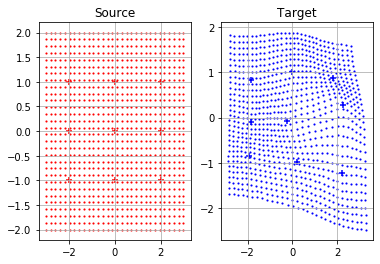

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform

def makeT(cp):
    # cp: [K x 2] control points
    # T: [(K+3) x (K+3)]
    K = cp.shape[0]
    T = np.zeros((K+3, K+3))
    T[:K, 0] = 1
    T[:K, 1:3] = cp
    T[K, 3:] = 1
    T[K+1:, 3:] = cp.T
    R = squareform(pdist(cp, metric='euclidean'))
    R = R * R
    R[R == 0] = 1 # a trick to make R ln(R) 0
    R = R * np.log(R)
    np.fill_diagonal(R, 0)
    T[:K, 3:] = R
    return T

def liftPts(p, cp):
    # p: [N x 2], input points
    # cp: [K x 2], control points
    # pLift: [N x (3+K)], lifted input points
    N, K = p.shape[0], cp.shape[0]
    pLift = np.zeros((N, K+3))
    pLift[:,0] = 1
    pLift[:,1:3] = p
    R = cdist(p, cp, 'euclidean')
    R = R * R
    R[R == 0] = 1
    R = R * np.log(R)
    pLift[:,3:] = R
    return pLift

# source control points
x, y = np.linspace(-2, 2, 3), np.linspace(-1, 1, 3)
x, y = np.meshgrid(x, y)
xs = x.flatten()
ys = y.flatten()
cps = np.vstack([xs, ys]).T

# target control points
xt = xs + np.random.uniform(-0.3, 0.3, size=xs.size)
yt = ys + np.random.uniform(-0.3, 0.3, size=ys.size)

# construct T
T = makeT(cps)

# solve cx, cy (coefficients for x and y)
xtAug = np.concatenate([xt, np.zeros(3)])
ytAug = np.concatenate([yt, np.zeros(3)])
print(T.shape, xtAug.shape)
cx = nl.solve(T, xtAug) # [K+3]
cy = nl.solve(T, ytAug)

# dense grid
N = 30
x = np.linspace(-3, 3, N)
y = np.linspace(-2, 2, N)
x, y = np.meshgrid(x, y)
xgs, ygs = x.flatten(), y.flatten()
gps = np.vstack([xgs, ygs]).T

# transform
pgLift = liftPts(gps, cps) # [N x (K+3)]
xgt = np.dot(pgLift, cx.T)
ygt = np.dot(pgLift, cy.T)

# display
plt.xlim(-3.5, 3.5)
plt.ylim(-2.5, 2.5)
plt.subplot(1, 2, 1)
plt.title('Source')
plt.grid()
plt.scatter(xs, ys, marker='+', c='r', s=40)
plt.scatter(xgs, ygs, marker='.', c='r', s=5)

plt.subplot(1, 2, 2)
plt.title('Target')
plt.grid()
plt.scatter(xt, yt, marker='+', c='b', s=40)
plt.scatter(xgt, ygt, marker='.', c='b', s=5)
plt.show()

# Testing TPS transform interface

In [84]:
from vos.utils.tps_transform import get_all_tcps, image_tps_transform
from vos.datasets.COCO import COCO
from vos.datasets.ECSSD import ECSSD
from vos.datasets.MSRA10K import MSRA10K
from vos.datasets.SBD import SBD
from vos.datasets.VOC import VOCSegmentation

# root = "/p300/videoObjSeg_dataset/COCO-2017-train"
# cocod = COCO(root, mode= "train", max_n_objects= 2, sort_anns= True)

# ecssdroot = "/p300/videoObjSeg_dataset/ECSSD"
# dataset = ECSSD(ecssdroot)

msraroot = "/p300/videoObjSeg_dataset/MSRA10K_Imgs_GT"
dataset = MSRA10K(msraroot)

# sbdroot = "/p300/videoObjSeg_dataset/SBD"
# dataset = SBD(sbdroot)

# vocroot = "/p300/videoObjSeg_dataset/VOC"
# dataset = VOCSegmentation(vocroot)

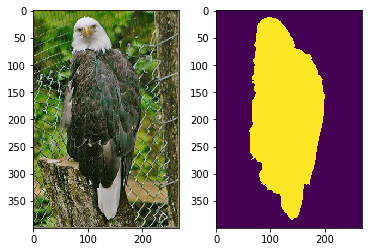

In [117]:
idx = np.random.choice(len(dataset), 1)[0]
data = dataset[idx]
image = data["image"].numpy()
mask = data["mask"].numpy()

plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[2])
plt.subplot(1, 2, 1)
plt.imshow(image.transpose(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(mask[1])

In [118]:
_, ys, xs = np.nonzero(mask[1:] == 1)
print(xs.shape, ys.shape)
idxs = np.random.choice(len(xs), 5)
interest_cps = np.vstack((xs[idxs], ys[idxs])).T
print(interest_cps)

(35066,) (35066,)
[[168 245]
 [109 325]
 [130 170]
 [ 69 233]
 [180  99]]


In [119]:
scale = 0.1
jitter_scale = np.sqrt(xs.shape[0]) / (mask.shape[0]-1) * scale
target_cps = interest_cps + np.random.uniform(-jitter_scale, jitter_scale, size= interest_cps.shape)
print(target_cps)

[[166.93142357 245.73917176]
 [101.54602496 317.56799413]
 [116.26349586 176.59883114]
 [ 83.89004366 247.72651963]
 [186.17156987 107.29139342]]


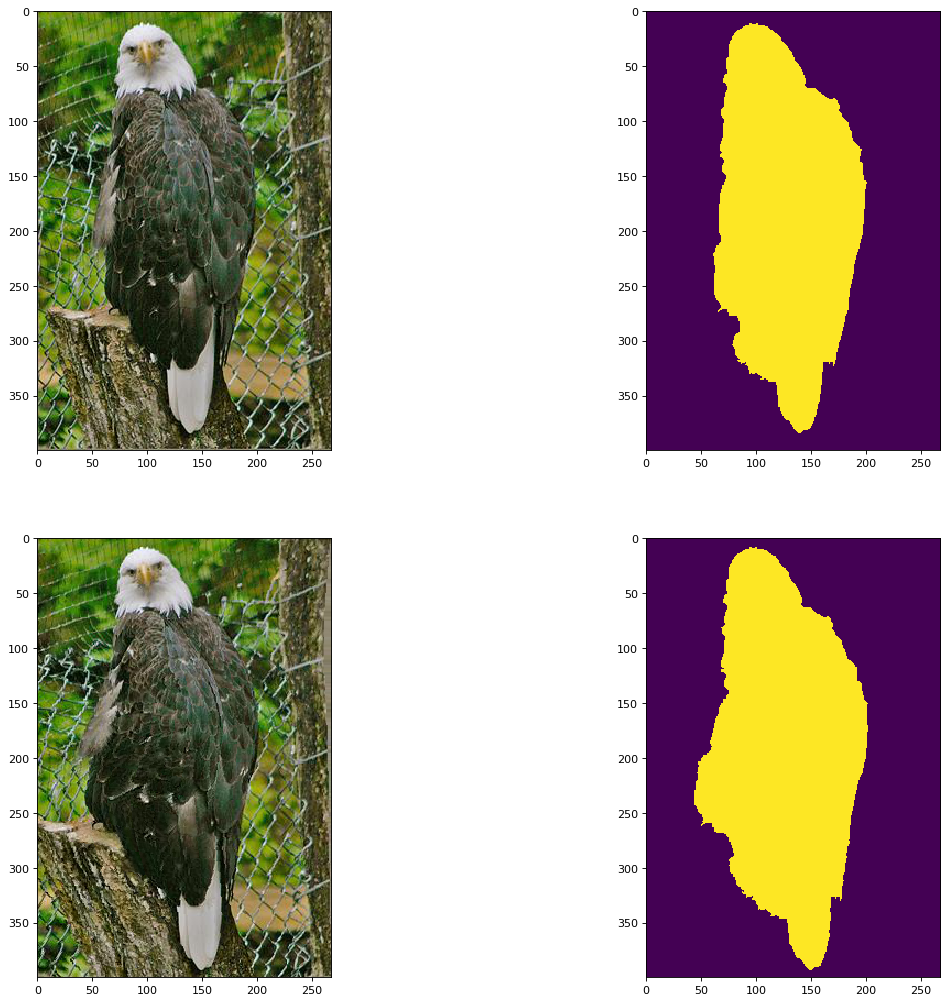

In [120]:
tps_image = image_tps_transform(image, interest_cps, target_cps)
tps_mask = image_tps_transform(mask, interest_cps, target_cps)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[2])
plt.subplot(2,2, 1)
plt.imshow(image.transpose(1,2,0))
plt.subplot(2,2, 2)
plt.imshow(mask[1])
plt.subplot(2,2, 3)
plt.imshow(tps_image.transpose(1,2,0))
plt.subplot(2,2, 4)
plt.imshow(tps_mask[1])